# Extreme disaster impact on portfolio

In [350]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import statsmodels.tsa.api as smt
from scipy.stats import norm, genpareto

## Working with 30 sectors daily returns over the covid period

In [131]:
df= pd.read_excel('IndustryReturn.xlsx',sheet_name='Sheet1')

In [132]:
df.head()

,Unnamed: 0,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
0,19260701,0.05,-1.39,0.00,0.47,-0.10,-0.90,0.12,0.97,0.57,...,-0.02,2.26,-0.23,-0.93,0.14,2.77,-0.02,0.27,0.58,-1.66
1,19260702,0.10,0.78,0.70,0.13,1.29,-0.34,-0.35,0.13,0.98,...,0.26,0.08,0.94,1.07,0.07,0.00,0.01,-0.10,-0.16,3.09
2,19260706,0.08,-1.74,0.50,-0.12,1.51,-1.20,0.41,0.23,0.19,...,0.17,-0.19,0.56,0.73,-0.20,0.77,-0.22,-0.67,0.20,1.41
3,19260707,0.58,-1.73,-0.12,-0.09,-0.49,-0.22,0.16,0.33,0.80,...,0.32,1.38,-0.52,2.22,0.19,-3.21,-0.57,-1.08,-0.07,0.62
4,19260708,0.95,-0.15,0.30,0.19,0.00,-0.01,0.79,0.91,-0.13,...,0.40,-0.43,0.52,-0.39,0.46,-1.10,-0.38,0.33,-0.48,0.98


In [133]:
df.rename(columns={'Unnamed: 0':'Date'},inplace= True)

In [134]:
df.drop(df.index[-1],inplace= True)

### Dividing the data into pre and post covid

In [222]:
df_covid = df[(df['Date']> 20191001) & (df['Date']< 20200931)]
df_covid_pre = df[(df['Date']>= 20191001) & (df['Date']<= 20200331)]
df_covid_post = df[(df['Date']>= 20200401) & (df['Date']<= 20200931)]

In [225]:
df_covid_post.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,-3.19,-2.16,-2.61,-4.72,-4.86,-1.83,-5.76,-4.00,-5.37,-11.00,...,-3.01,-4.55,-4.88,-3.07,-5.78,-4.27,-2.38,-5.02,-5.87,-3.98
2020-04-02,2.66,3.43,1.32,0.12,-1.16,3.55,0.93,3.47,0.92,-2.24,...,2.97,1.18,2.83,2.37,0.84,-0.55,0.87,0.05,2.20,2.49
2020-04-03,0.85,0.78,0.48,-3.27,-2.35,0.04,-1.59,-0.68,-2.64,-4.32,...,-2.39,-1.73,-1.75,-2.66,-2.37,-3.17,-0.74,-2.25,-2.83,-1.77
2020-04-06,3.86,5.27,1.74,6.65,7.13,3.58,8.97,4.97,7.87,14.42,...,5.98,7.96,8.34,5.44,7.65,8.16,6.10,10.78,8.62,4.47
2020-04-07,-0.02,0.46,0.23,0.52,1.28,-2.32,1.48,-1.34,3.09,8.79,...,1.17,-0.46,-0.86,1.00,0.12,0.90,0.17,1.23,0.62,-0.50


In [224]:
df_covid_post['Date'] = pd.to_datetime(df_covid_post['Date'], format='%Y%m%d')
df_covid_pre['Date'] = pd.to_datetime(df_covid_pre['Date'], format='%Y%m%d')
df_covid_post = df_covid_post.set_index('Date')
df_covid_pre = df_covid_pre.set_index('Date')

/tmp/ipykernel_79146/3496385266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_post['Date'] = pd.to_datetime(df_covid_post['Date'], format='%Y%m%d')
/tmp/ipykernel_79146/3496385266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_pre['Date'] = pd.to_datetime(df_covid_pre['Date'], format='%Y%m%d')


In [226]:
df_covid_post = df_covid_post.asfreq('d')
df_covid_pre = df_covid_pre.asfreq('d')

In [323]:
df_covid_post.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,-3.19,-2.16,-2.61,-4.72,-4.86,-1.83,-5.76,-4.00,-5.37,-11.00,...,-3.01,-4.55,-4.88,-3.07,-5.78,-4.27,-2.38,-5.02,-5.87,-3.98
2020-04-02,2.66,3.43,1.32,0.12,-1.16,3.55,0.93,3.47,0.92,-2.24,...,2.97,1.18,2.83,2.37,0.84,-0.55,0.87,0.05,2.20,2.49
2020-04-03,0.85,0.78,0.48,-3.27,-2.35,0.04,-1.59,-0.68,-2.64,-4.32,...,-2.39,-1.73,-1.75,-2.66,-2.37,-3.17,-0.74,-2.25,-2.83,-1.77
2020-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
df_covid_pre.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2019-10-01 to 2020-03-31
Freq: D
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    126 non-null    float64
 1   Beer    126 non-null    float64
 2   Smoke   126 non-null    float64
 3   Games   126 non-null    float64
 4   Books   126 non-null    float64
 5   Hshld   126 non-null    float64
 6   Clths   126 non-null    float64
 7   Hlth    126 non-null    float64
 8   Chems   126 non-null    float64
 9   Txtls   126 non-null    float64
 10  Cnstr   126 non-null    float64
 11  Steel   126 non-null    float64
 12  FabPr   126 non-null    float64
 13  ElcEq   126 non-null    float64
 14  Autos   126 non-null    float64
 15  Carry   126 non-null    float64
 16  Mines   126 non-null    float64
 17  Coal    126 non-null    float64
 18  Oil     126 non-null    float64
 19  Util    126 non-null    float64
 20  Telcm   126 non-null    float64
 21  Servs   126 

- Making a function to plot pacf and acf

In [209]:
# Plot ACF and PACF
def plot_acf_pacf(returns,name):
    plt.figure()
    plot_acf(returns, lags=40)
    plt.title(name+' ACF')
    plt.figure()
    plot_pacf(returns, lags=40,method='ywm')
    plt.title(name+' PACF')
    plt.show();

- Finding the best parameters for the AR and MA components by looping through the p and q values for all the sectors individually
- Storing the residuals for later analysis

In [881]:
garch_result = []

In [885]:
i =0
# Find best parameters
best_params = {}
best_aic={}
res = {}
for i in range(0,30):
    best_aic[i] = np.inf
# Loop over sectors
for i in range(0,30):
    returns = df_covid_pre[df_covid_pre.columns[i]].dropna()
    #plot_acf_pacf(returns,df_covid_pre.columns[i])
    
    for p in range(1, 7):
        for q in range(1, 7):
                arma_model = ARIMA(returns.asfreq('d'),order=(p,0,q))
                arma_result = arma_model.fit()
                if arma_result.aic < best_aic[i]:
                    best_params[df_covid_pre.columns[i]] = [p,0,q]
                    best_aic[i] = arma_result.aic
                    
    res[df_covid_pre.columns[i]] = \
        arch_model(returns, vol="GARCH", \
        p=best_params[df_covid_pre.columns[i]][0], o=1, q=best_params[df_covid_pre.columns[i]][2]).fit().resid
    res[df_covid_pre.columns[i]] = (res[df_covid_pre.columns[i]] - res[df_covid_pre.columns[i]].mean()) / res[df_covid_pre.columns[i]].std()

    #arch_model(returns.asfreq('d'),order=best_params[i]).fit().resid

Iteration:      1,   Func. Count:     12,   Neg. LLF: 1738.6055991213157
Iteration:      2,   Func. Count:     27,   Neg. LLF: 24703480.37480049
Iteration:      3,   Func. Count:     39,   Neg. LLF: 298.69217216767584
Iteration:      4,   Func. Count:     51,   Neg. LLF: 186.31566669600454
Iteration:      5,   Func. Count:     63,   Neg. LLF: 185.88983732416162
Iteration:      6,   Func. Count:     75,   Neg. LLF: 181.9444439299172
Iteration:      7,   Func. Count:     87,   Neg. LLF: 172.14871578524674
Iteration:      8,   Func. Count:     99,   Neg. LLF: 177.34606284424584
Iteration:      9,   Func. Count:    111,   Neg. LLF: 172.70502532958838
Iteration:     10,   Func. Count:    123,   Neg. LLF: 168.76475933591703
Iteration:     11,   Func. Count:    134,   Neg. LLF: 169.01421758620617
Iteration:     12,   Func. Count:    146,   Neg. LLF: 168.69703631618816
Iteration:     13,   Func. Count:    157,   Neg. LLF: 168.63794815904137
Iteration:     14,   Func. Count:    168,   Neg. LLF:

Below are the p and q values obtained for corresponding lowest AIC values 

In [908]:
best_params

{'Food': [2, 0, 5],
 'Beer': [6, 0, 2],
 'Smoke': [5, 0, 6],
 'Games': [5, 0, 3],
 'Books': [6, 0, 3],
 'Hshld': [6, 0, 2],
 'Clths': [6, 0, 6],
 'Hlth': [2, 0, 5],
 'Chems': [5, 0, 5],
 'Txtls': [4, 0, 2],
 'Cnstr': [6, 0, 6],
 'Steel': [5, 0, 6],
 'FabPr': [2, 0, 5],
 'ElcEq': [6, 0, 4],
 'Autos': [5, 0, 3],
 'Carry': [6, 0, 6],
 'Mines': [5, 0, 6],
 'Coal': [4, 0, 2],
 'Oil': [5, 0, 4],
 'Util': [6, 0, 5],
 'Telcm': [2, 0, 5],
 'Servs': [5, 0, 6],
 'BusEq': [3, 0, 1],
 'Paper': [2, 0, 5],
 'Trans': [5, 0, 3],
 'Whlsl': [6, 0, 4],
 'Rtail': [3, 0, 2],
 'Meals': [6, 0, 6],
 'Fin': [6, 0, 6],
 'Other': [3, 0, 2]}

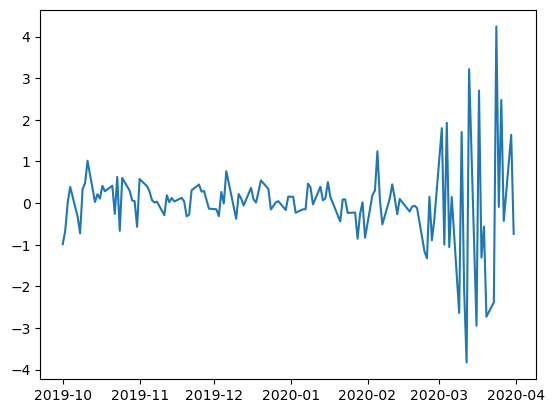

In [887]:
plt.plot(res['Paper'])

Histogram of the residuals of the __Beer__ sector

(array([ 3.,  0.,  2.,  7., 53., 54.,  3.,  0.,  3.,  1.]),
 array([-4.17074833, -3.32316268, -2.47557702, -1.62799136, -0.7804057 ,
         0.06717996,  0.91476562,  1.76235128,  2.60993693,  3.45752259,
         4.30510825]),
 <BarContainer object of 10 artists>)

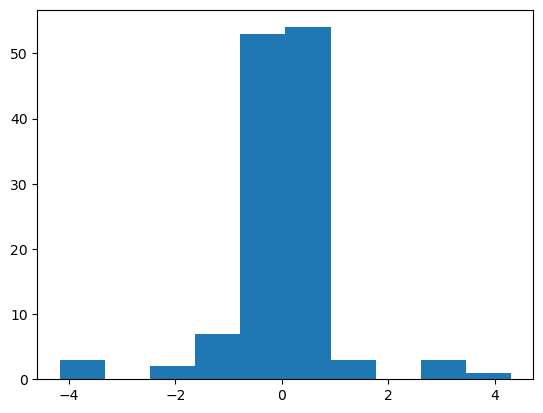

In [888]:
plt.hist(res['Beer'])

Two perito distributions on either side of a normal distribution are clearly seen

<AxesSubplot: ylabel='Density'>

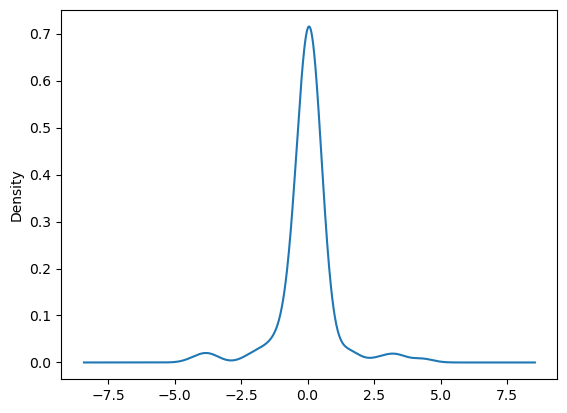

In [889]:
res['Beer'].plot.density(bw_method=0.4)

Checking the cutoff at 5 for 'Beer' sector

In [890]:
sum(res['Beer'] > 5)

0

(array([5., 0., 1., 4., 1., 0., 0., 0., 1., 1.]),
 array([0.59701544, 0.94315284, 1.28929025, 1.63542765, 1.98156505,
        2.32770246, 2.67383986, 3.01997726, 3.36611466, 3.71225207,
        4.05838947]),
 <BarContainer object of 10 artists>)

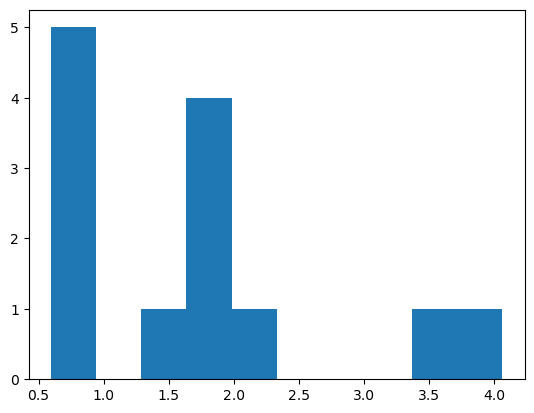

In [891]:
top5= {}
bottom5 = {}
interior = {}
gpd_params_bottom = {}
gpd_params_top = {}
mu= {}
std = {}
i=0
for i in res.keys():
    top5_cutoff, bottom5_cutoff = res[i].sort_values().quantile(0.90), res[i].sort_values().quantile(0.10) 
    top5[i] = res[i].sort_values()[res[i].sort_values() >= top5_cutoff]
    bottom5[i] = res[i].sort_values()[res[i].sort_values() <= bottom5_cutoff]
    interior[i] = res[i].sort_values()[(res[i].sort_values() > bottom5_cutoff) & (res[i].sort_values() >= top5_cutoff)]
    # fit a Generalized Pareto Distribution to the tail values
    gpd_params_top[i] = genpareto.fit(top5[i], loc=top5_cutoff)
    gpd_params_bottom[i] = genpareto.fit(bottom5[i], loc=bottom5_cutoff)    
    # fit a Gaussian Distribution to the remaining values
    mu[i], std[i] = norm.fit(interior[i])
plt.hist(top5[i])

In [892]:
for i in res.keys():
    print("GPD parameters for {} sector \n the top parameters ={} \n bottom parameters = {}".format(i, gpd_params_top[i], gpd_params_bottom[i]))
    print("Gaussian distribution parameters: mu={}, std={} ".format(mu[i], std[i]))

GPD parameters for Food sector 
 the top parameters =(-0.7644461073383055, 0.5452913455608839, 2.3357275115211658) 
 bottom parameters = (0.9023522619068075, -1.5912904693329055, 7.081375653459912e-17)
Gaussian distribution parameters: mu=1.741502802429417, std=0.9883712959435299 
GPD parameters for Beer sector 
 the top parameters =(1.8727229233769975, 0.4883636846007988, 0.1737408448359274) 
 bottom parameters = (1.3053444453258112, -0.7422131106679154, 3.902134995832234e-30)
Gaussian distribution parameters: mu=1.6716347802287954, std=1.2610283768117414 
GPD parameters for Smoke sector 
 the top parameters =(-0.25108612252578666, 0.7342625518062948, 1.2684880100424847) 
 bottom parameters = (1.2088904811492416, -0.9625069078073054, 1.1503689114384862e-28)
Gaussian distribution parameters: mu=1.7368692424007421, std=0.8912838714097583 
GPD parameters for Games sector 
 the top parameters =(-0.2481602616553531, 0.7732818036367628, 0.8840959536518658) 
 bottom parameters = (1.145093459

In [427]:
from scipy.stats import uniform
from scipy.optimize import root
from scipy.optimize import brentq

In [772]:
def inverse_mixture_model_cdf(params_top, params_bottom, mu, std, x):
    
    # Define the CDF of the mixture model
    def cdf_mixture(q):
        return 0.1* genpareto.cdf(q, *params_top) + \
               0.1 * genpareto.cdf(q, *params_bottom) + \
               0.8 * norm.cdf(q, loc=mu, scale=std)
    

    # Define the inverse CDF of the mixture model
    #def inv_cdf_mixture(q):
     #   return root(lambda z: cdf_mixture(z) - q, x0=0).x[0]
    #print(inv_cdf_mixture(x))
    # Transform the inverse CDF to a uniform distribution
    #return uniform.cdf(inv_cdf_mixture(x))
    return inv_cdf_mixture(x)

In [773]:
def cdf_mixture(params_top, params_bottom, mu, std, x):
        return 0.1* genpareto.cdf(x, *params_top) + \
               0.1 * genpareto.cdf(x, *params_bottom) + \
               0.8 * norm.cdf(x, loc=mu, scale=std)


In [893]:
res_cdf = {}
for j in res.keys():
    for ja in res[j].sort_values():
        if j in res_cdf.keys():            
            res_cdf[j].append(cdf_mixture(gpd_params_top[j],gpd_params_bottom[j],mu[j],std[j], ja))
        else:
            res_cdf[j] = [cdf_mixture(gpd_params_top[j],gpd_params_bottom[j],mu[j],std[j], ja)]


## Fitting copula

In [894]:
from pycopula.copula import ArchimedeanCopula
from pycopula.copula import GaussianCopula
from pycop import archimedean, estimation
from copulae import EmpiricalCopula
import copulae
from pycopula.visualization import pdf_2d, cdf_2d
import statsmodels
from statsmodels.distributions.copula.api import (CopulaDistribution,GumbelCopula,ClaytonCopula)

In [895]:
data = pd.DataFrame(res_cdf).to_numpy()

In [896]:
data[0:3]

array([[4.31689749e-10, 1.44140468e-06, 2.84014838e-10, 1.22056496e-25,
        1.32472377e-15, 2.98220796e-06, 6.94556308e-10, 1.00040658e-10,
        4.27554709e-12, 7.20525584e-13, 9.63802690e-10, 2.16696730e-10,
        1.31061200e-08, 1.19022755e-10, 1.71811676e-10, 4.11468766e-07,
        6.82134887e-08, 5.27081491e-06, 1.14232726e-11, 2.23962109e-06,
        2.83694410e-08, 6.48096999e-11, 3.48875963e-10, 1.96626058e-08,
        4.98941124e-08, 5.64788329e-11, 1.27756821e-11, 9.57090440e-07,
        1.39590798e-08, 4.44640117e-08],
       [3.53514441e-08, 6.41861739e-06, 5.02154417e-10, 1.00657835e-17,
        4.73904082e-09, 2.68166176e-05, 4.58796627e-08, 4.01634405e-08,
        1.34768539e-08, 1.84147735e-06, 1.99024731e-07, 1.99962408e-09,
        6.96173884e-08, 4.67475286e-08, 1.15396281e-08, 6.20760288e-06,
        3.73742890e-06, 3.23657568e-05, 2.99333445e-07, 9.17483710e-06,
        4.97343146e-08, 2.78389465e-07, 1.68021607e-07, 1.64255539e-06,
        3.36508251e-07,

In [900]:
res.keys()

dict_keys(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth', 'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'])

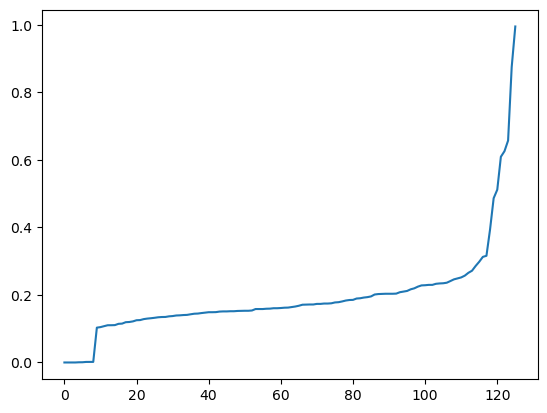

In [901]:
plt.plot(res_cdf['Oil'])

Text(0.5, 0, 'Residual Value')

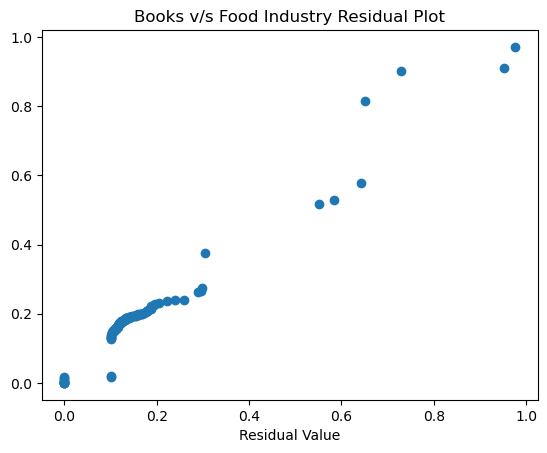

In [1055]:
plt.scatter(res_cdf['Books'],res_cdf['Beer'])
plt.title('Books v/s Food Industry Residual Plot')
plt.xlabel('Residual Value')

In [903]:
df_fit = pd.DataFrame(res_cdf)
df_fit.to_csv('res_cdf')

In [938]:
df_fit

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
0,4.316897e-10,0.000001,2.840148e-10,1.220565e-25,1.324724e-15,0.000003,6.945563e-10,1.000407e-10,4.275547e-12,7.205256e-13,...,2.836944e-08,6.480970e-11,3.488760e-10,1.966261e-08,4.989411e-08,5.647883e-11,1.277568e-11,9.570904e-07,1.395908e-08,4.446401e-08
1,3.535144e-08,0.000006,5.021544e-10,1.006578e-17,4.739041e-09,0.000027,4.587966e-08,4.016344e-08,1.347685e-08,1.841477e-06,...,4.973431e-08,2.783895e-07,1.680216e-07,1.642555e-06,3.365083e-07,2.320577e-09,8.517342e-11,6.872969e-04,5.634417e-06,5.709845e-08
2,7.142774e-06,0.000011,2.206622e-09,1.169186e-11,7.792505e-09,0.000052,5.247471e-05,3.128190e-06,4.192029e-08,7.465291e-06,...,3.767696e-06,1.398290e-05,4.880154e-06,4.373685e-06,1.176196e-06,9.115215e-07,2.263769e-05,7.841544e-04,6.809017e-06,8.385661e-06
3,1.718370e-05,0.000919,3.733604e-07,1.083210e-09,3.499078e-08,0.000129,3.479934e-04,2.880078e-05,5.238215e-07,5.788023e-05,...,6.368081e-06,2.349269e-04,2.508879e-04,6.536673e-06,8.787222e-06,3.856430e-06,2.980023e-05,1.373138e-03,3.553266e-05,1.344322e-05
4,1.907585e-05,0.001745,4.094853e-06,1.785013e-07,2.199322e-06,0.000653,3.824517e-04,5.652336e-05,2.712358e-05,5.914481e-04,...,3.729576e-04,3.671879e-04,3.306042e-04,1.915852e-05,2.845709e-04,1.680939e-05,3.907073e-05,4.024796e-03,7.031407e-04,6.147085e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,7.318238e-01,0.578807,7.004152e-01,5.562936e-01,6.430001e-01,0.719857,5.631363e-01,7.095360e-01,6.188811e-01,4.770613e-01,...,6.100297e-01,6.828044e-01,7.056891e-01,5.853467e-01,5.666496e-01,5.435337e-01,6.847155e-01,4.911222e-01,6.022767e-01,6.301182e-01
122,7.911509e-01,0.814455,7.328443e-01,8.289439e-01,6.507047e-01,0.754219,5.713841e-01,8.369831e-01,6.782007e-01,5.938837e-01,...,6.393702e-01,7.515277e-01,7.366290e-01,7.579808e-01,6.272615e-01,6.452813e-01,6.945396e-01,6.951697e-01,6.406669e-01,6.351254e-01
123,8.811277e-01,0.901463,7.672160e-01,8.939867e-01,7.298476e-01,0.839839,6.813821e-01,8.907609e-01,8.210166e-01,7.764967e-01,...,8.404443e-01,7.525887e-01,7.509824e-01,8.162375e-01,6.829615e-01,8.813401e-01,7.550846e-01,7.012364e-01,7.330609e-01,7.323986e-01
124,9.115223e-01,0.911062,8.923721e-01,9.372522e-01,9.529933e-01,0.921845,8.183227e-01,9.058016e-01,9.084499e-01,7.992552e-01,...,9.255721e-01,9.431989e-01,9.642102e-01,9.142719e-01,9.183443e-01,9.215501e-01,9.671481e-01,9.065364e-01,9.740805e-01,9.492838e-01


In [668]:
sector_names = []
for i in res.keys():
    sector_names.append(i)

## Copula Fitting

In [939]:
# gum = GumbelCopula()
#gum.fit_corr_param(df_fit[['Food','Books']])


In [907]:
copula = ClaytonCopula()
copula.fit_corr_param(df_fit[['Food','Beer']])

824.5373694584716

In [947]:
copula = ClaytonCopula()
df_cop_pre_param = pd.DataFrame(columns=sector_names, index=sector_names)
for i in sector_names:
    for j in sector_names:
        if i != j:
            df_cop_pre_param[i][j] = copula.fit_corr_param(df_fit[[i,j]])
        else:
            df_cop_pre_param[i][j] = 0

In [948]:
df_cop_pre_param

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0,824.537369,803.180143,979.812377,847.062737,949.984297,1012.104691,680.36479,1045.817407,950.457918,...,949.576674,1081.299539,922.055247,870.456762,824.65645,824.315789,949.841091,921.650512,950.292709,824.65645
Beer,824.537369,0,803.390518,980.015593,1081.527923,1081.527923,1082.212595,921.498091,1427.115443,1495.040593,...,803.390518,1011.62225,1120.306086,922.0,1120.14795,824.537369,950.061522,783.302494,1162.141178,1045.337769
Smoke,803.180143,803.390518,0,847.170845,746.020354,922.031076,980.441054,613.508974,1012.04651,1045.759719,...,921.647059,824.761713,847.170845,803.390518,949.962303,895.200815,745.913808,764.000593,1206.763087,949.962303
Games,979.812377,980.015593,847.170845,0,1255.201597,1081.79429,1365.30989,824.55648,1121.045838,1162.552754,...,895.697056,1081.79429,1045.733333,980.015593,1045.604436,824.781059,1011.751282,922.148723,1162.382695,1120.433664
Books,847.062737,1081.527923,746.020354,1255.201597,0,871.0,1308.277618,846.825878,1365.135977,1207.283938,...,824.761713,1045.6,1011.872006,1364.190902,1011.742974,803.519316,980.003898,803.60614,1120.734658,1011.742974
Hshld,949.984297,1081.527923,922.031076,1081.79429,871.0,0,1308.277618,803.290338,1162.585622,1427.165189,...,1045.239925,922.352941,1162.075443,895.778759,1081.656359,764.224196,870.891968,895.677506,1120.734658,1081.656359
Clths,1012.104691,1082.212595,980.441054,1365.30989,1308.277618,1308.277618,0,896.016485,1848.474045,1570.809987,...,1045.950741,1121.081493,1365.30989,1162.53609,1162.629449,1082.060214,1427.297261,1012.175542,1570.63995,1255.809407
Hlth,680.36479,921.498091,613.508974,824.55648,846.825878,803.290338,896.016485,0,980.139985,895.836991,...,728.026429,803.290338,711.828243,711.596966,745.700471,601.628654,846.682781,625.865519,728.621022,979.390359
Chems,1045.817407,1427.115443,1012.04651,1121.045838,1365.135977,1162.585622,1848.474045,980.139985,0,1495.811788,...,1081.993721,1495.349066,1207.437784,1120.841624,1427.222968,871.150914,1082.16511,1120.754805,1365.408293,1308.110951
Txtls,950.457918,1495.040593,1045.759719,1162.552754,1207.283938,1427.165189,1570.809987,895.836991,1495.811788,0,...,1045.759719,1120.902981,1495.294711,1162.333153,1255.59828,1081.85579,1045.937647,1011.996645,1308.340267,1162.437474


## Post Covid Data

In [910]:
i =0
# Find best parameters
best_params_post = {}
best_aic_post={}
res_post = {}
for i in range(0,30):
    best_aic_post[i] = np.inf
# Loop over sectors
for i in range(0,30):
    returns = df_covid_post[df_covid_post.columns[i]].dropna()
    #plot_acf_pacf(returns,df_covid_pre.columns[i])
    
    for p in range(1, 7):
        for q in range(1, 7):
                arma_model_post = ARIMA(returns.asfreq('d'),order=(p,0,q))
                arma_result_post = arma_model.fit()
                if arma_result_post.aic < best_aic_post[i]:
                    best_params_post[df_covid_post.columns[i]] = [p,0,q]
                    best_aic_post[i] = arma_result_post.aic
                    
    res_post[df_covid_post.columns[i]] = \
        arch_model(returns, vol="GARCH", \
        p=best_params_post[df_covid_post.columns[i]][0], o=1, q=best_params_post[df_covid_post.columns[i]][2]).fit().resid
    res_post[df_covid_post.columns[i]] = (res_post[df_covid_post.columns[i]] - res_post[df_covid_post.columns[i]].mean()) / res_post[df_covid_post.columns[i]].std()

    #arch_model(returns.asfreq('d'),order=best_params[i]).fit().resid

Iteration:      1,   Func. Count:      7,   Neg. LLF: 466.7417035329753
Iteration:      2,   Func. Count:     16,   Neg. LLF: 187745204.7523569
Iteration:      3,   Func. Count:     24,   Neg. LLF: 444.0995680630317
Iteration:      4,   Func. Count:     31,   Neg. LLF: 226.98676348061284
Iteration:      5,   Func. Count:     38,   Neg. LLF: 223.6727129524481
Iteration:      6,   Func. Count:     45,   Neg. LLF: 220.33986042333794
Iteration:      7,   Func. Count:     52,   Neg. LLF: 216.32975108858588
Iteration:      8,   Func. Count:     59,   Neg. LLF: 213.56048081805824
Iteration:      9,   Func. Count:     66,   Neg. LLF: 214.45472443617854
Iteration:     10,   Func. Count:     73,   Neg. LLF: 210.53617611539204
Iteration:     11,   Func. Count:     80,   Neg. LLF: 234.84309616230772
Iteration:     12,   Func. Count:     87,   Neg. LLF: 210.16032288580413
Iteration:     13,   Func. Count:     94,   Neg. LLF: 211.31442030543306
Iteration:     14,   Func. Count:    101,   Neg. LLF: 2

Below are the p and q values obtained for corresponding lowest AIC values 

In [914]:
best_params_post

{'Food': [1, 0, 1],
 'Beer': [1, 0, 1],
 'Smoke': [1, 0, 1],
 'Games': [1, 0, 1],
 'Books': [1, 0, 1],
 'Hshld': [1, 0, 1],
 'Clths': [1, 0, 1],
 'Hlth': [1, 0, 1],
 'Chems': [1, 0, 1],
 'Txtls': [1, 0, 1],
 'Cnstr': [1, 0, 1],
 'Steel': [1, 0, 1],
 'FabPr': [1, 0, 1],
 'ElcEq': [1, 0, 1],
 'Autos': [1, 0, 1],
 'Carry': [1, 0, 1],
 'Mines': [1, 0, 1],
 'Coal': [1, 0, 1],
 'Oil': [1, 0, 1],
 'Util': [1, 0, 1],
 'Telcm': [1, 0, 1],
 'Servs': [1, 0, 1],
 'BusEq': [1, 0, 1],
 'Paper': [1, 0, 1],
 'Trans': [1, 0, 1],
 'Whlsl': [1, 0, 1],
 'Rtail': [1, 0, 1],
 'Meals': [1, 0, 1],
 'Fin': [1, 0, 1],
 'Other': [1, 0, 1]}

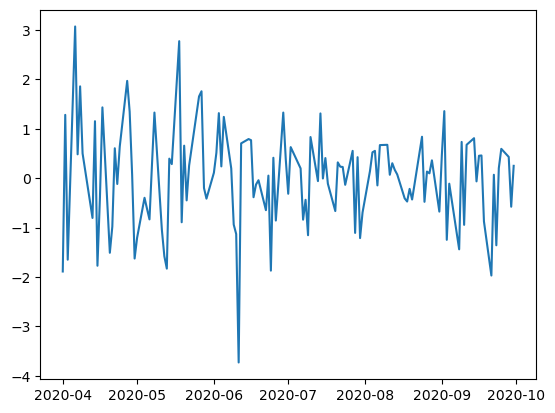

In [915]:
plt.plot(res_post['Paper'])

Histogram of the residuals of the __Beer__ sector

(array([ 1.,  1.,  9., 18., 45., 38.,  8.,  5.,  0.,  2.]),
 array([-3.4720813 , -2.74196055, -2.0118398 , -1.28171904, -0.55159829,
         0.17852246,  0.90864321,  1.63876396,  2.36888471,  3.09900546,
         3.82912621]),
 <BarContainer object of 10 artists>)

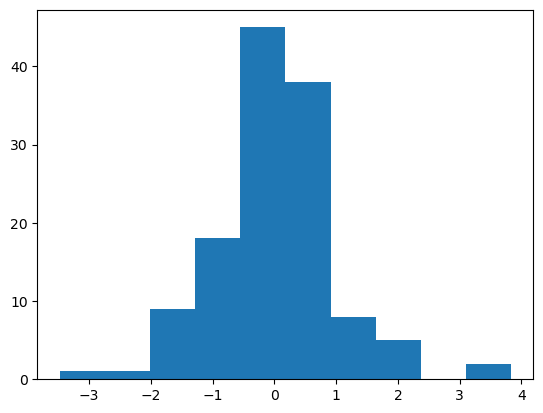

In [916]:
plt.hist(res_post['Beer'])

Two perito distributions on either side of a normal distribution are clearly seen

Text(0.5, 0, 'Residual Value')

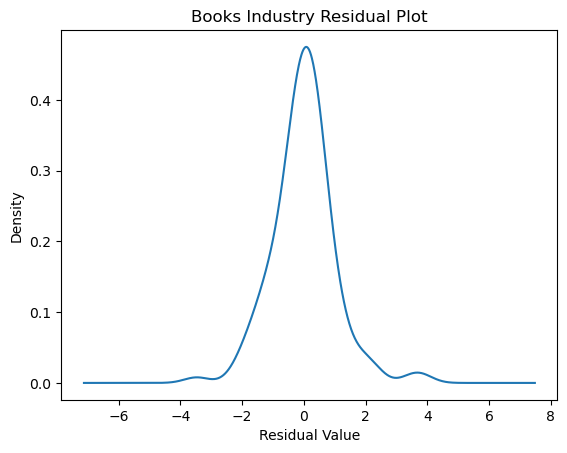

In [1072]:
res_post['Beer'].plot.density(bw_method=0.4)
plt.title('Books Industry Residual Plot')
plt.xlabel('Residual Value')

Checking the cutoff at 5 for 'Beer' sector

In [967]:
post_g = []
for i in sector_names:
    for j in sector_names:
        if i != j:
            post_g.append([i,j,df_cop_post_param[i][j]])

In [918]:
sum(res_post['Beer'] > 5)

0

(array([3., 2., 1., 2., 3., 0., 0., 1., 0., 1.]),
 array([1.07761749, 1.26540693, 1.45319637, 1.6409858 , 1.82877524,
        2.01656468, 2.20435412, 2.39214355, 2.57993299, 2.76772243,
        2.95551187]),
 <BarContainer object of 10 artists>)

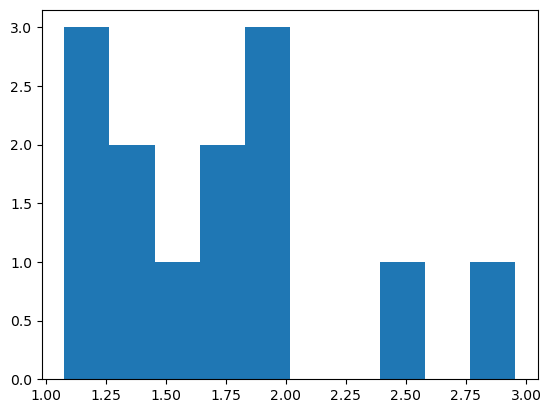

In [919]:
top5_post= {}
bottom5_post = {}
interior_post = {}
gpd_params_bottom_post = {}
gpd_params_top_post = {}
mu_post= {}
std_post = {}
i=0
for i in res.keys():
    top5_cutoff_post, bottom5_cutoff_post = res_post[i].sort_values().quantile(0.90), res_post[i].sort_values().quantile(0.10) 
    top5_post[i] = res_post[i].sort_values()[res_post[i].sort_values() >= top5_cutoff_post]
    bottom5_post[i] = res_post[i].sort_values()[res_post[i].sort_values() <= bottom5_cutoff_post]
    interior_post[i] = res_post[i].sort_values()[(res_post[i].sort_values() > bottom5_cutoff_post) & (res_post[i].sort_values() >= top5_cutoff_post)]
    # fit a Generalized Pareto Distribution to the tail values
    gpd_params_top_post[i] = genpareto.fit(top5_post[i], loc=top5_cutoff_post)
    gpd_params_bottom_post[i] = genpareto.fit(bottom5_post[i], loc=bottom5_cutoff_post)    
    # fit a Gaussian Distribution to the remaining values
    mu_post[i], std_post[i] = norm.fit(interior_post[i])
plt.hist(top5_post[i])

In [920]:
for i in res_post.keys():
    print("GPD parameters for {} sector \n the top parameters ={} \n bottom parameters = {}".format(i, gpd_params_top_post[i], gpd_params_bottom_post[i]))
    print("Gaussian distribution parameters: mu={}, std={} ".format(mu_post[i], std_post[i]))

GPD parameters for Food sector 
 the top parameters =(1.210029115678085, 1.1903983835634695, 0.2999445073955882) 
 bottom parameters = (1.0796974488631088, -2.0077247521840023, 0.1293921417957799)
Gaussian distribution parameters: mu=1.696820685321712, std=0.472804696967638 
GPD parameters for Beer sector 
 the top parameters =(0.18311314816059684, 1.078246329087467, 0.6630320857203104) 
 bottom parameters = (-1.9137468848352044, -2.202675862844429, 2.017126399070688)
Gaussian distribution parameters: mu=1.879591905899582, std=0.8588790429933375 
GPD parameters for Smoke sector 
 the top parameters =(0.07137997325054769, 1.3577016774674049, 0.3379076313421506) 
 bottom parameters = (-0.5417162255149492, -1.884588086684146, 0.3615517582220096)
Gaussian distribution parameters: mu=1.7211098729159415, std=0.37578669622524696 
GPD parameters for Games sector 
 the top parameters =(1.32909270007577, 1.1171028846897357, 0.2701094469014051) 
 bottom parameters = (1.3103255249103225, -1.747314

In [921]:
from scipy.stats import uniform
from scipy.optimize import root
from scipy.optimize import brentq

In [772]:
def inverse_mixture_model_cdf(params_top, params_bottom, mu, std, x):
    
    # Define the CDF of the mixture model
    def cdf_mixture(q):
        return 0.1* genpareto.cdf(q, *params_top) + \
               0.1 * genpareto.cdf(q, *params_bottom) + \
               0.8 * norm.cdf(q, loc=mu, scale=std)
    

    # Define the inverse CDF of the mixture model
    #def inv_cdf_mixture(q):
     #   return root(lambda z: cdf_mixture(z) - q, x0=0).x[0]
    #print(inv_cdf_mixture(x))
    # Transform the inverse CDF to a uniform distribution
    #return uniform.cdf(inv_cdf_mixture(x))
    return inv_cdf_mixture(x)

In [773]:
def cdf_mixture(params_top, params_bottom, mu, std, x):
        return 0.1* genpareto.cdf(x, *params_top) + \
               0.1 * genpareto.cdf(x, *params_bottom) + \
               0.8 * norm.cdf(x, loc=mu, scale=std)


In [922]:
res_cdf_post = {}
for j in res_post.keys():
    for ja in res_post[j].sort_values():
        if j in res_cdf_post.keys():            
            res_cdf_post[j].append(cdf_mixture(gpd_params_top_post[j],gpd_params_bottom_post[j],mu_post[j],std_post[j], ja))
        else:
            res_cdf_post[j] = [cdf_mixture(gpd_params_top_post[j],gpd_params_bottom_post[j],mu_post[j],std_post[j], ja)]


## Fitting copula

In [923]:
from pycopula.copula import ArchimedeanCopula
from pycopula.copula import GaussianCopula
from pycop import archimedean, estimation
from copulae import EmpiricalCopula
import copulae
from pycopula.visualization import pdf_2d, cdf_2d
import statsmodels
from statsmodels.distributions.copula.api import (CopulaDistribution,GumbelCopula,ClaytonCopula)

In [924]:
data_post = pd.DataFrame(res_cdf_post).to_numpy()

In [925]:
data_post[0:3]

array([[6.10873153e-32, 1.85389755e-10, 2.96316404e-42, 2.41760121e-10,
        8.87387847e-18, 1.16850724e-17, 6.63664017e-13, 1.83776840e-19,
        2.64752634e-16, 4.49273978e-18, 6.54182756e-11, 7.18709609e-46,
        2.70619274e-15, 4.98925219e-13, 1.58063758e-65, 1.28083889e-13,
        1.53792069e-16, 1.79110353e-13, 2.14675157e-13, 1.26801356e-11,
        1.49529054e-12, 1.81538792e-08, 4.58507642e-12, 3.26696797e-23,
        1.19296294e-16, 5.37996318e-11, 5.36513103e-10, 8.18827683e-07,
        1.65260856e-17, 8.72008467e-27],
       [3.06217051e-19, 9.89640654e-04, 4.27997623e-37, 3.17387042e-10,
        1.18438047e-15, 2.27621783e-04, 2.09093187e-11, 3.33262498e-14,
        3.67225721e-11, 1.47788287e-12, 2.66787401e-09, 1.65731903e-27,
        3.06842024e-11, 1.18525910e-12, 1.01023187e-32, 5.87047748e-10,
        6.44107839e-10, 2.40963445e-09, 3.19019896e-03, 6.50563321e-09,
        2.34908598e-07, 6.25119332e-08, 1.15333574e-10, 7.76503637e-10,
        1.36150136e-11,

In [926]:
res_post.keys()

dict_keys(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth', 'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'])

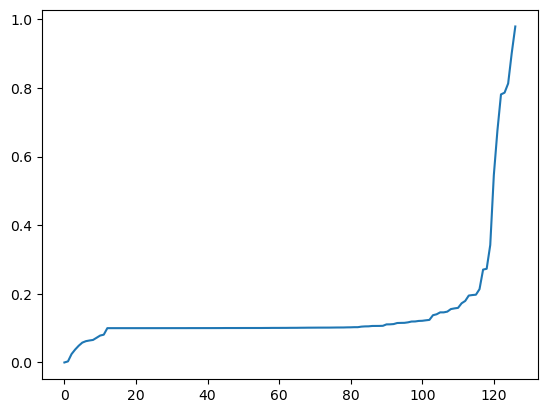

In [927]:
plt.plot(res_cdf_post['Oil'])

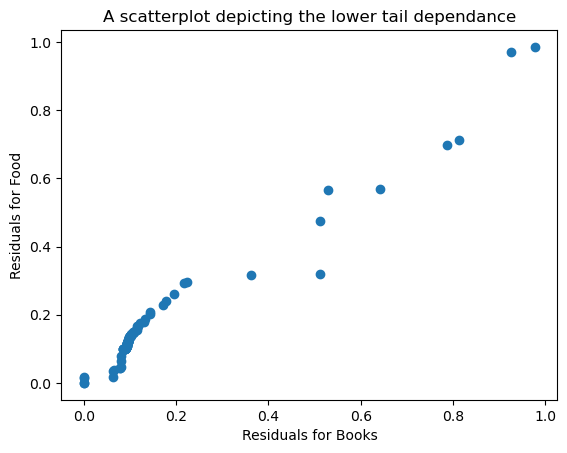

In [1075]:
plt.scatter(res_cdf_post['Books'],res_cdf_post['Beer'])
plt.xlabel('Residuals for Books')
plt.ylabel('Residuals for Food')
plt.title('A scatterplot depicting the lower tail dependance');

In [949]:
df_fit_post = pd.DataFrame(res_cdf_post)
df_fit_post.to_csv('res_cdf_post')

In [950]:
copula = ClaytonCopula()
df_cop_post_param = pd.DataFrame(columns=sector_names, index=sector_names)
for i in sector_names:
    for j in sector_names:
        if i != j:
            df_cop_post_param[i][j] = copula.fit_corr_param(df_fit_post[[i,j]])
        else:
            df_cop_post_param[i][j] = 0

In [951]:
df_cop_post_param

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0,757.913808,1276.141843,860.792468,910.237411,965.686652,1028.491794,1028.491794,965.528778,1227.094081,...,995.535087,996.015363,1099.373037,1028.304579,1138.611952,1062.750746,757.532856,936.996425,937.145152,965.528778
Beer,757.913808,0,1276.270034,860.979532,1028.154997,1099.368506,1181.350909,1181.350909,1028.154997,1227.212614,...,884.891968,1062.737649,1028.471227,1099.544423,1138.795781,1138.984485,757.750473,937.190282,996.035087,1099.202087
Smoke,1276.141843,1276.270034,0,1329.673373,1773.752886,1596.289892,2662.361091,1996.265609,1773.752886,3551.12345,...,1387.53279,1680.490225,1996.062439,1996.062439,1878.439358,2457.283982,1028.587243,1387.631176,2129.017596,1450.859334
Games,860.792468,860.979532,1329.673373,0,1138.719379,1450.033013,1595.759816,1595.759816,1138.719379,1520.083589,...,965.697886,1181.219422,1226.822401,1329.229076,1275.879939,1519.539545,860.62873,1099.311532,1181.049362,1226.467446
Books,910.237411,1028.154997,1773.752886,1138.719379,0,1139.005093,1595.889892,1995.390494,1329.0,1680.434666,...,1275.534378,1519.448953,1773.16044,1450.396649,1519.448953,1276.199939,816.521111,1099.449463,1275.841597,1138.857143
Hshld,965.686652,1099.368506,1596.289892,1450.033013,1139.005093,0,1596.039951,1596.039951,1450.190071,1680.556636,...,1028.413062,1387.306235,1450.553708,1595.809988,1519.621312,2128.573297,910.240451,1099.596889,1387.132322,1329.173601
Clths,1028.491794,1181.350909,2662.361091,1595.759816,1595.889892,1596.039951,0,1774.0,1450.619736,2457.591674,...,1276.12941,1520.020382,1773.79011,1773.79011,1680.235428,1680.423819,965.906683,1387.396848,1519.866141,1450.619736
Hlth,1028.491794,1181.350909,1996.265609,1595.759816,1995.390494,1596.039951,1774.0,0,1450.619736,2129.639963,...,1181.444267,1878.148756,1773.79011,1596.209988,1878.148756,2129.071107,910.579857,1276.238282,1519.866141,1329.562409
Chems,965.528778,1028.154997,1773.752886,1138.719379,1329.0,1450.190071,1450.619736,1450.619736,0,1520.183454,...,1180.901214,1387.147424,1450.396649,1329.36107,1276.014378,1877.733476,910.080535,1099.449463,1275.841597,1226.615385
Txtls,1227.094081,1227.212614,3551.12345,1520.083589,1680.434666,1680.556636,2457.591674,2129.639963,1520.183454,0,...,1596.15963,1774.110993,2129.444346,1878.674652,1774.110993,1996.312439,937.712098,1450.933629,1995.999781,1520.183454


In [982]:
df_final_cop = df_cop_post_param - df_cop_pre_param

In [983]:
df_final_cop

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0,-66.623561,472.9617,-119.019909,63.174674,15.702355,16.387103,348.127004,-80.28863,276.636163,...,45.958413,-85.284176,177.31779,157.847817,313.955502,238.434957,-192.308235,15.345914,-13.147556,140.872327
Beer,-66.623561,0,472.879516,-119.036061,-53.372926,17.840583,99.138313,259.852818,-398.960446,-267.827979,...,81.50145,51.115399,-91.834859,177.544423,18.647831,314.447115,-192.311049,153.887789,-166.106091,53.864318
Smoke,472.9617,472.879516,0,482.502528,1027.732532,674.258817,1681.920037,1382.756635,761.706376,2505.363731,...,465.885731,855.728512,1148.891595,1192.671921,928.477055,1562.083167,282.673435,623.630583,922.254509,500.897031
Games,-119.019909,-119.036061,482.502528,0,-116.482219,368.238723,230.449926,771.203335,17.67354,357.530835,...,70.000831,99.425131,181.089068,349.213482,230.275503,694.758486,-151.122552,177.162809,18.666667,106.033782
Books,63.174674,-53.372926,1027.732532,-116.482219,0,268.005093,287.612275,1148.564617,-36.135977,473.150728,...,450.772664,473.848953,761.288433,86.205748,507.705979,472.680622,-163.482787,295.843323,155.10694,127.114169
Hshld,15.702355,17.840583,674.258817,368.238723,268.005093,0,287.762333,792.749613,287.604449,253.391447,...,-16.826864,464.953294,288.478264,700.031228,437.964953,1364.3491,39.348482,203.919383,266.397665,247.517241
Clths,16.387103,99.138313,1681.920037,230.449926,287.612275,287.762333,0,877.983515,-397.854309,886.781686,...,230.17867,398.938888,408.48022,611.25402,517.605978,598.363605,-461.390579,375.221306,-50.773809,194.810329
Hlth,348.127004,259.852818,1382.756635,771.203335,1148.564617,792.749613,877.983515,0,470.479752,1233.802972,...,453.417838,1074.858419,1061.961867,884.613021,1132.448286,1527.442453,63.897076,650.372763,791.245118,350.172051
Chems,-80.28863,-398.960446,761.706376,17.67354,-36.135977,287.604449,-397.854309,470.479752,0,24.371666,...,98.907493,-108.201642,242.958865,208.519446,-151.20859,1006.582562,-172.084576,-21.305342,-89.566695,-81.495566
Txtls,276.636163,-267.827979,2505.363731,357.530835,473.150728,253.391447,886.781686,1233.802972,24.371666,0,...,550.399912,653.208012,634.149635,716.341499,518.512713,914.456649,-108.225549,438.936984,687.659514,357.74598


In [984]:
def convert_value(x):
    if x > 0:
        return 1
    elif x == 0:
        return ''
    else:
        return 0

# apply the function to each element of the dataframe using applymap()
df_final_cop = df_final_cop.applymap(convert_value)

In [1004]:
df_final_cop['Chems'].value_counts()

1    17
0    12
      1
Name: Chems, dtype: int64

In [952]:
import networkx as nx

In [1043]:
df_final_cop

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,,0,1,0,1,1,1,1,0,1,...,1,0,1,1,1,1,0,1,0,1
Beer,0,,1,0,0,1,1,1,0,0,...,1,1,0,1,1,1,0,1,0,1
Smoke,1,1,,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Games,0,0,1,,0,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
Books,1,0,1,0,,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1
Hshld,1,1,1,1,1,,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
Clths,1,1,1,1,1,1,,1,0,1,...,1,1,1,1,1,1,0,1,0,1
Hlth,1,1,1,1,1,1,1,,1,1,...,1,1,1,1,1,1,1,1,1,1
Chems,0,0,1,1,0,1,0,1,,1,...,1,0,1,1,0,1,0,0,0,0
Txtls,1,0,1,1,1,1,1,1,1,,...,1,1,1,1,1,1,0,1,1,1


In [996]:
post_g = []
for i in sector_names:
    for j in sector_names:
        if i != j and df_final_cop[i][j] ==1:
            post_g.append([i,j,df_final_cop[i][j]])

In [997]:
G = nx.Graph()
G.add_weighted_edges_from(post_g)

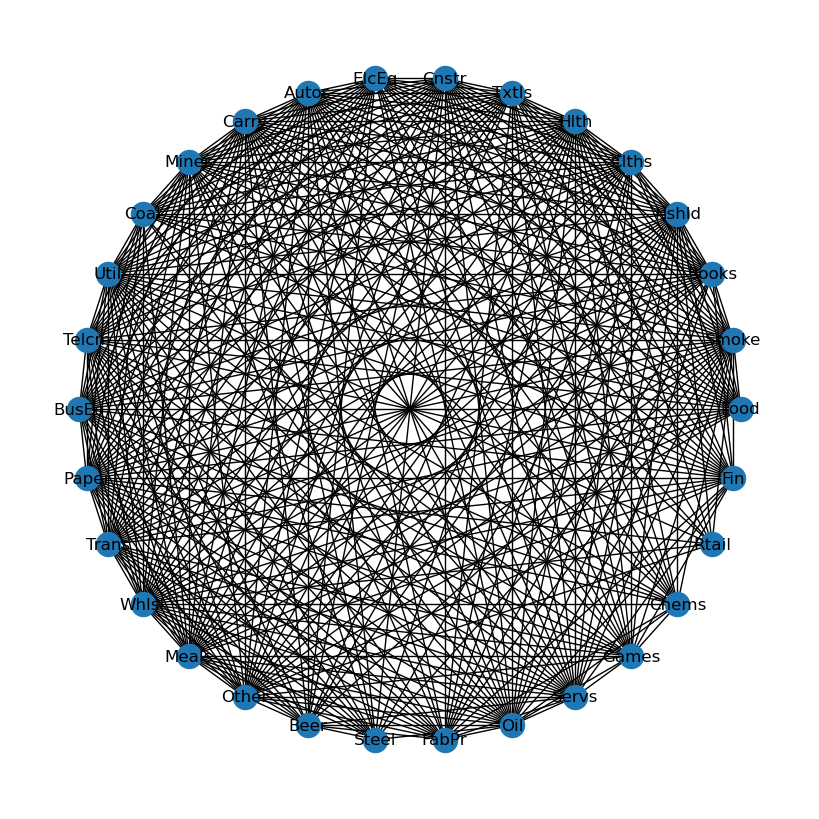

In [1078]:
pos=nx.circular_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True)
edge_weight = nx.get_edge_attributes(G,"weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
plt.show()

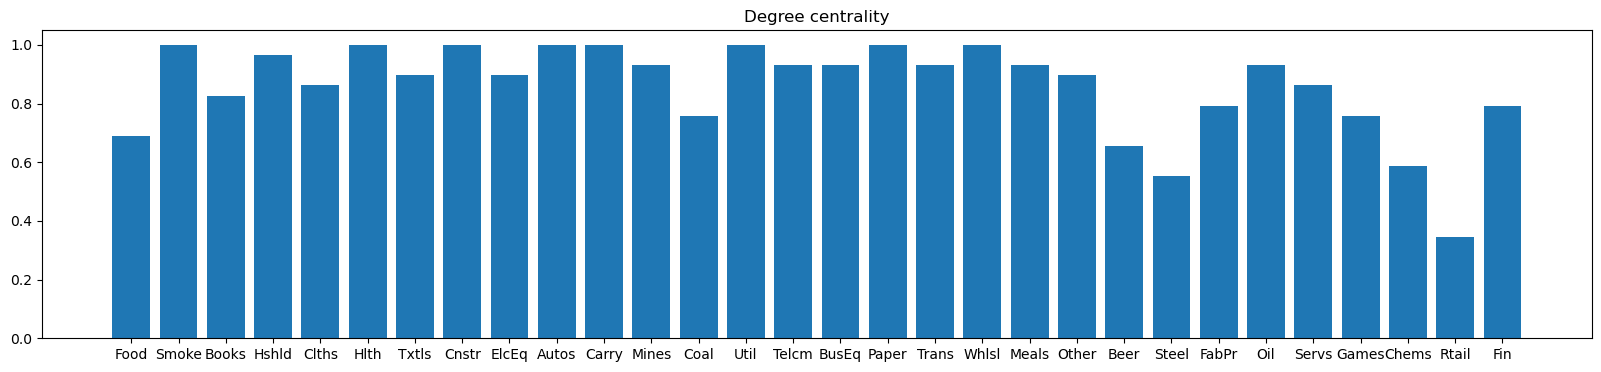

In [1016]:
# create a bar chart for degree centrality
plt.figure(figsize=(20, 4))
plt.bar(degree_centrality.keys(), degree_centrality.values())
plt.title("Degree centrality")
plt.show()


In [1060]:
degree_centrality

{'Food': 0.6896551724137931,
 'Smoke': 1.0,
 'Books': 0.8275862068965517,
 'Hshld': 0.9655172413793103,
 'Clths': 0.8620689655172413,
 'Hlth': 1.0,
 'Txtls': 0.896551724137931,
 'Cnstr': 1.0,
 'ElcEq': 0.896551724137931,
 'Autos': 1.0,
 'Carry': 1.0,
 'Mines': 0.9310344827586207,
 'Coal': 0.7586206896551724,
 'Util': 1.0,
 'Telcm': 0.9310344827586207,
 'BusEq': 0.9310344827586207,
 'Paper': 1.0,
 'Trans': 0.9310344827586207,
 'Whlsl': 1.0,
 'Meals': 0.9310344827586207,
 'Other': 0.896551724137931,
 'Beer': 0.6551724137931034,
 'Steel': 0.5517241379310345,
 'FabPr': 0.7931034482758621,
 'Oil': 0.9310344827586207,
 'Servs': 0.8620689655172413,
 'Games': 0.7586206896551724,
 'Chems': 0.5862068965517241,
 'Rtail': 0.3448275862068966,
 'Fin': 0.7931034482758621}

In [1061]:
table_data = pd.DataFrame(list(degree_centrality.items()), columns=["Node", "Centrality Value"])
table_data['Centrality Value'] = table_data['Centrality Value']*29
print(table_data)

     Node  Centrality Value
0    Food              20.0
1   Smoke              29.0
2   Books              24.0
3   Hshld              28.0
4   Clths              25.0
5    Hlth              29.0
6   Txtls              26.0
7   Cnstr              29.0
8   ElcEq              26.0
9   Autos              29.0
10  Carry              29.0
11  Mines              27.0
12   Coal              22.0
13   Util              29.0
14  Telcm              27.0
15  BusEq              27.0
16  Paper              29.0
17  Trans              27.0
18  Whlsl              29.0
19  Meals              27.0
20  Other              26.0
21   Beer              19.0
22  Steel              16.0
23  FabPr              23.0
24    Oil              27.0
25  Servs              25.0
26  Games              22.0
27  Chems              17.0
28  Rtail              10.0
29    Fin              23.0


In [1020]:
copula = ClaytonCopula()
copula.fit_corr_param(df_fit_post[['Beer','Smoke']])


1276.2700340174283

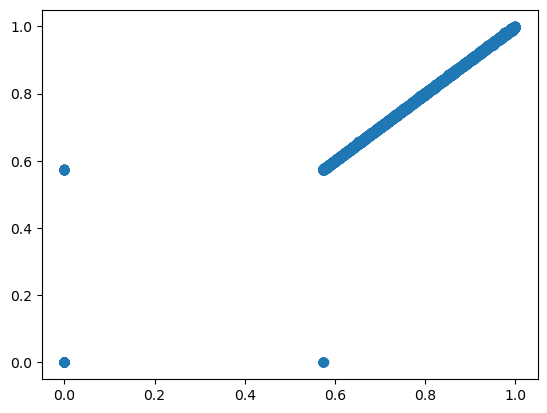

In [1048]:


# generate random samples from the copula
samples = copula.rvs(args=copula.fit_corr_param(df_fit_post[['Beer','Smoke']]),nobs=100000)

df_cop_plot = pd.DataFrame(samples)

plt.scatter(df_cop_plot[0],df_cop_plot[1])

In [1042]:
df_cop_plot[1]

0      0.965861
1      0.792183
2      0.000000
3      0.000000
4      0.000000
         ...   
995    0.000000
996    0.000000
997    0.000000
998    0.000000
999    0.807807
Name: 1, Length: 1000, dtype: float64

In [1010]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# print out the results
print("Degree centrality:")
print(degree_centrality)
print("\nBetweenness centrality:")
print(betweenness_centrality)
print("\nEigenvector centrality:")
print(eigenvector_centrality)

Degree centrality:
{'Food': 0.6896551724137931, 'Smoke': 1.0, 'Books': 0.8275862068965517, 'Hshld': 0.9655172413793103, 'Clths': 0.8620689655172413, 'Hlth': 1.0, 'Txtls': 0.896551724137931, 'Cnstr': 1.0, 'ElcEq': 0.896551724137931, 'Autos': 1.0, 'Carry': 1.0, 'Mines': 0.9310344827586207, 'Coal': 0.7586206896551724, 'Util': 1.0, 'Telcm': 0.9310344827586207, 'BusEq': 0.9310344827586207, 'Paper': 1.0, 'Trans': 0.9310344827586207, 'Whlsl': 1.0, 'Meals': 0.9310344827586207, 'Other': 0.896551724137931, 'Beer': 0.6551724137931034, 'Steel': 0.5517241379310345, 'FabPr': 0.7931034482758621, 'Oil': 0.9310344827586207, 'Servs': 0.8620689655172413, 'Games': 0.7586206896551724, 'Chems': 0.5862068965517241, 'Rtail': 0.3448275862068966, 'Fin': 0.7931034482758621}

Betweenness centrality:
{'Food': 0.0002031812376639963, 'Smoke': 0.010986960102565668, 'Books': 0.0010532887653537854, 'Hshld': 0.010622063185944615, 'Clths': 0.002307102253188752, 'Hlth': 0.010986960102565668, 'Txtls': 0.00291124459136235, 

In [ ]:
post_g = []
for i in sector_names:
    for j in sector_names:
        if i != j:
            post_g.append([i,j,df_cop_post_param[i][j]])

In [969]:
G = nx.Graph()
G.add_weighted_edges_from(post_g)

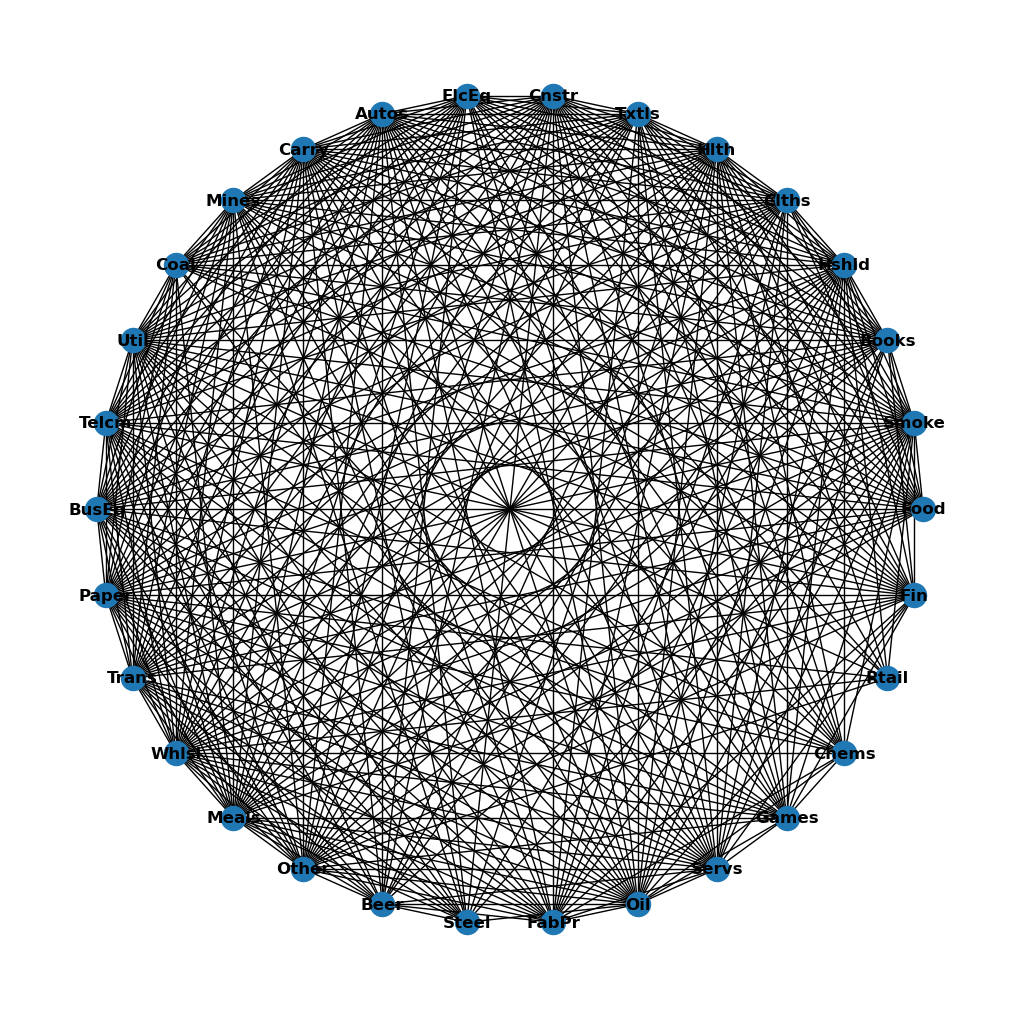

In [1049]:
pos=nx.circular_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, font_weight="bold")
edge_weight = nx.get_edge_attributes(G,"weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)
plt.show()